In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 불러오기 및 전처리
df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df = df[df['region'] == '강남구'].sort_values('datetime')
df = df.dropna(subset=['no2','co','so2','o3','pm10','pm25','diesel','electric','gasoline'])

# 예측하고자 하는 차량 유형 선택 (diesel, electric, gasoline)
vehicle_col = 'diesel'  # 또는 'electric', 'gasoline'

# 입력 변수 및 타겟 변수 구성
features = ['no2','co','so2','o3','pm10','pm25', vehicle_col]
data = df[features].values

# 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시계열 데이터셋 생성 함수
def create_dataset(data, look_back=6):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back, :6])  # 오염물질 6종 예측
    return np.array(X), np.array(y)

look_back = 12  # 최근 6개월 데이터 사용
X, y = create_dataset(data_scaled, look_back)

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(64, input_shape=(look_back, len(features)), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(6))  # 오염물질 6종 예측
model.compile(loss='mse', optimizer='adam')

# 학습
model.fit(X, y, epochs=100, batch_size=8, verbose=1)

# 향후 n개월 예측 (예: 12개월)
n_months = 12
last_seq = data_scaled[-look_back:]
predictions = []
for _ in range(n_months):
    pred = model.predict(last_seq.reshape(1, look_back, len(features)))
    predictions.append(pred[0])
    # 차량 대수 예측도 필요하다면 별도 모델로 예측하거나, 실제 시나리오 반영
    next_vehicle = last_seq[-1, -1]  # 예시: 최근 값 유지
    next_input = np.concatenate([pred[0], [next_vehicle]])
    last_seq = np.vstack([last_seq[1:], next_input])

# 역정규화
predictions = scaler.inverse_transform(np.hstack([np.array(predictions), np.zeros((n_months,1))]))[:,:6]
pred_df = pd.DataFrame(predictions, columns=['no2','co','so2','o3','pm10','pm25'])
print(pred_df)

Epoch 1/100


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3378
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3007
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2547
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2060
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2038
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1748
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1780
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1777
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1643
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1523
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1446
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1337
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1362
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1221
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1140
Epoch 16/100
2/2 ━━━━━━━━━━━━━━

NameError: name 'last_date' is not defined

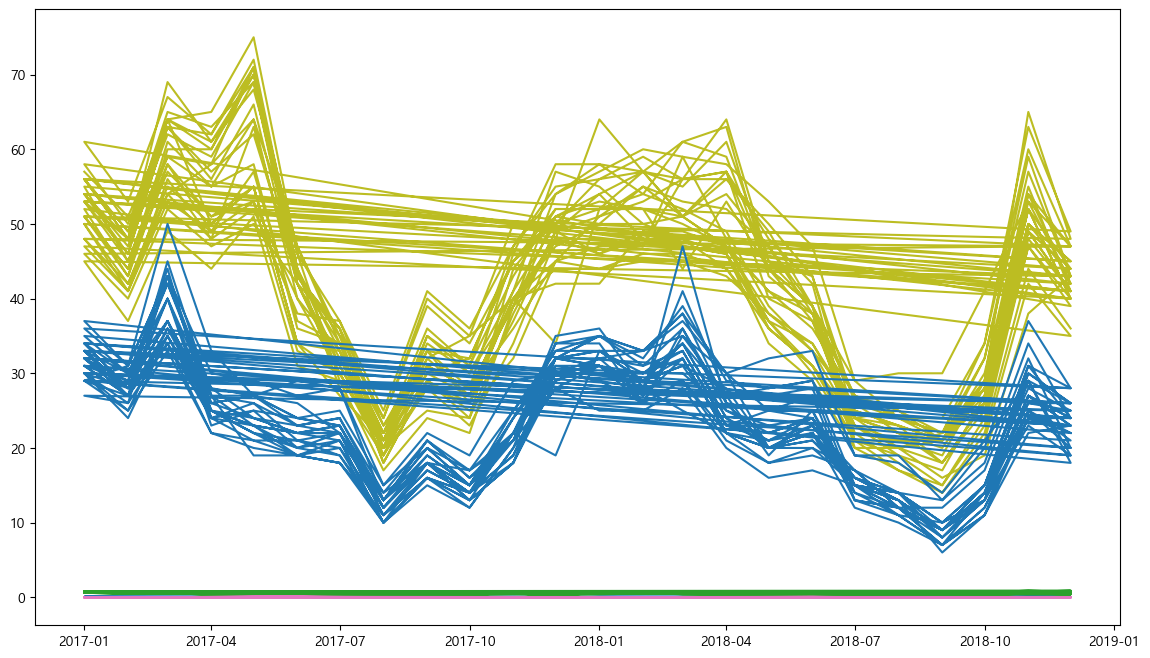

In [5]:
plot_df_actual = df[['datetime', 'no2', 'co', 'so2', 'o3', 'pm10', 'pm25']].copy()
plot_df_actual['type'] = 'actual'
plot_df_pred = pred_df.copy()
plot_df_pred['type'] = 'predicted'
plot_df_all = pd.concat([plot_df_actual, plot_df_pred], ignore_index=True)

# melt로 long-form 데이터로 변환
plot_melted = plot_df_all.melt(
    id_vars=['datetime', 'type'],
    value_vars=['no2', 'co', 'so2', 'o3', 'pm10', 'pm25'],
    var_name='pollutant',
    value_name='value'
)

# 시계열 그래프 그리기 (6종 오염물질)
plt.figure(figsize=(14, 8))
for pol in plot_melted['pollutant'].unique():
    actual = plot_melted[(plot_melted['pollutant'] == pol) & (plot_melted['type'] == 'actual')]
    predicted = plot_melted[(plot_melted['pollutant'] == pol) & (plot_melted['type'] == 'predicted')]
    plt.plot(
        pd.to_datetime(actual['datetime']),
        actual['value'],
        label=f'{pol} (actual)'
    )
    plt.plot(
        pd.to_datetime(predicted['datetime']),
        predicted['value'],
        label=f'{pol} (predicted)',
        linestyle='--'
    )
plt.axvline(
    x=last_date,
    color='gray',
    linestyle='--',
    label='Prediction Start'
)
plt.title('Actual vs Predicted (6 pollutants)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.grid(True)
plt.tight_layout()
plt.show()

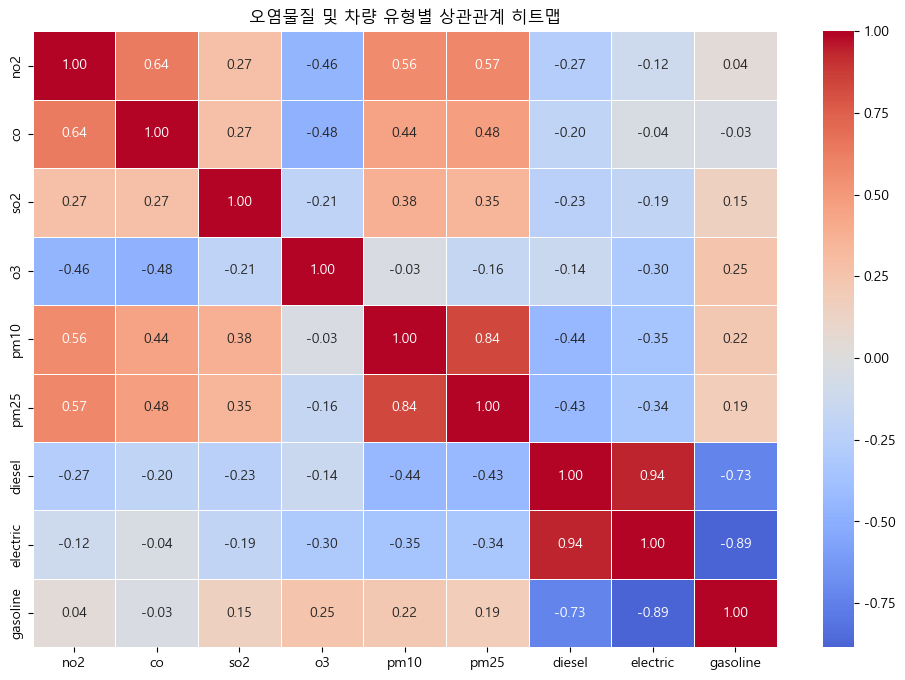

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df = df.dropna(subset=['no2', 'co', 'so2', 'o3', 'pm10', 'pm25', 'diesel', 'electric', 'gasoline'])

# 상관관계 계산
corr = df[['no2', 'co', 'so2', 'o3', 'pm10', 'pm25', 'diesel', 'electric', 'gasoline']].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    center=0
)
plt.title('오염물질 및 차량 유형별 상관관계 히트맵')
plt.show()

import matplotlib as mpl

# 폰트 설정
mpl.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import statsmodels.api as sm

# 데이터 불러오기 및 전처리
df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df = df.sort_values(['region', 'datetime'])

# 시차 변수 추가 (예: 1개월, 3개월, 6개월)
for lag in [1, 3, 6]:
    df[f'diesel_lag{lag}'] = df.groupby('region')['diesel'].shift(lag)

# 외생변수(예: temperature, policy_dummy) 추가
# df['temperature'] = ... (기상 데이터)
# df['policy_dummy'] = ... (정책 시행 시점 더미변수)

# 결측치 제거
df = df.dropna()

# 패널 회귀분석 (구별 고정효과, 시차 변수 포함)
df['region_code'] = pd.Categorical(df['region']).codes
df['month'] = pd.to_datetime(df['datetime']).dt.month

# 종속변수: no2, 독립변수: 디젤 시차, 기상, 정책 등
X = df[['diesel_lag1', 'diesel_lag3', 'diesel_lag6', 'temperature', 'policy_dummy']]
X = sm.add_constant(X)
y = df['no2']

model = sm.OLS(y, X).fit()
print(model.summary())

KeyError: "['temperature', 'policy_dummy'] not in index"

C:\Users\USER\AppData\Local\Temp\ipykernel_16252\3653797278.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(


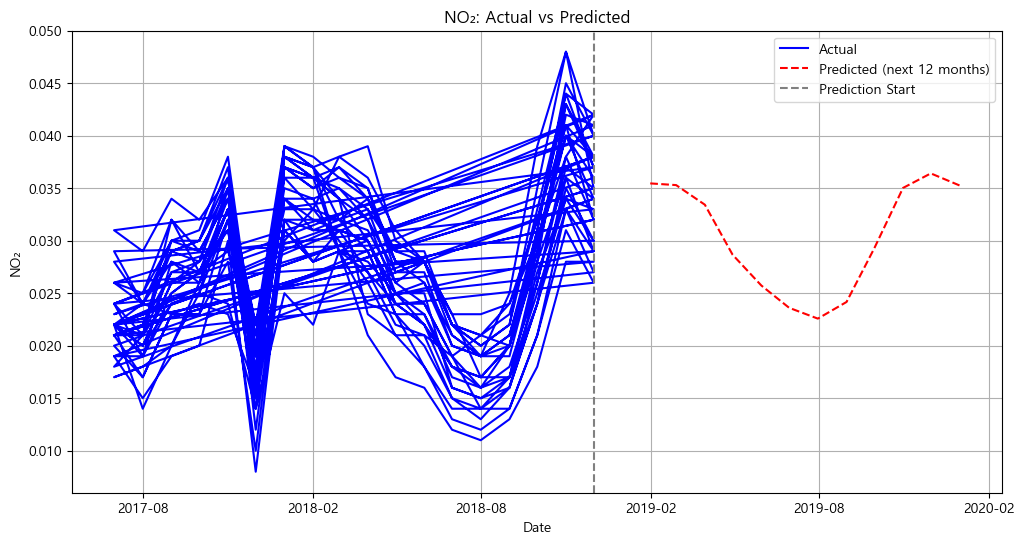

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 실제 데이터와 예측 데이터 준비
# 실제 데이터는 df, 예측 결과는 pred_df
# 예측 날짜 생성
last_date = pd.to_datetime(df['datetime'].iloc[-1])
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    periods=len(pred_df),
    freq='M'
)
pred_df['datetime'] = future_dates

# 실제 데이터(예: no2)와 예측 데이터 합치기
plot_df = pd.concat([
    df[['datetime', 'no2']].copy(),
    pred_df[['datetime', 'no2']].copy()
], ignore_index=True)
plot_df['type'] = 'actual'
plot_df.loc[len(df):, 'type'] = 'predicted'

# 2. 시계열 그래프 그리기 (예: NO₂)
plt.figure(figsize=(12, 6))
plt.plot(
    pd.to_datetime(df['datetime']),
    df['no2'],
    label='Actual',
    color='blue'
)
plt.plot(
    pred_df['datetime'],
    pred_df['no2'],
    label='Predicted (next 12 months)',
    color='red',
    linestyle='--'
)
plt.axvline(
    x=last_date,
    color='gray',
    linestyle='--',
    label='Prediction Start'
)
plt.title('NO₂: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('NO₂')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.grid(True)
plt.show()

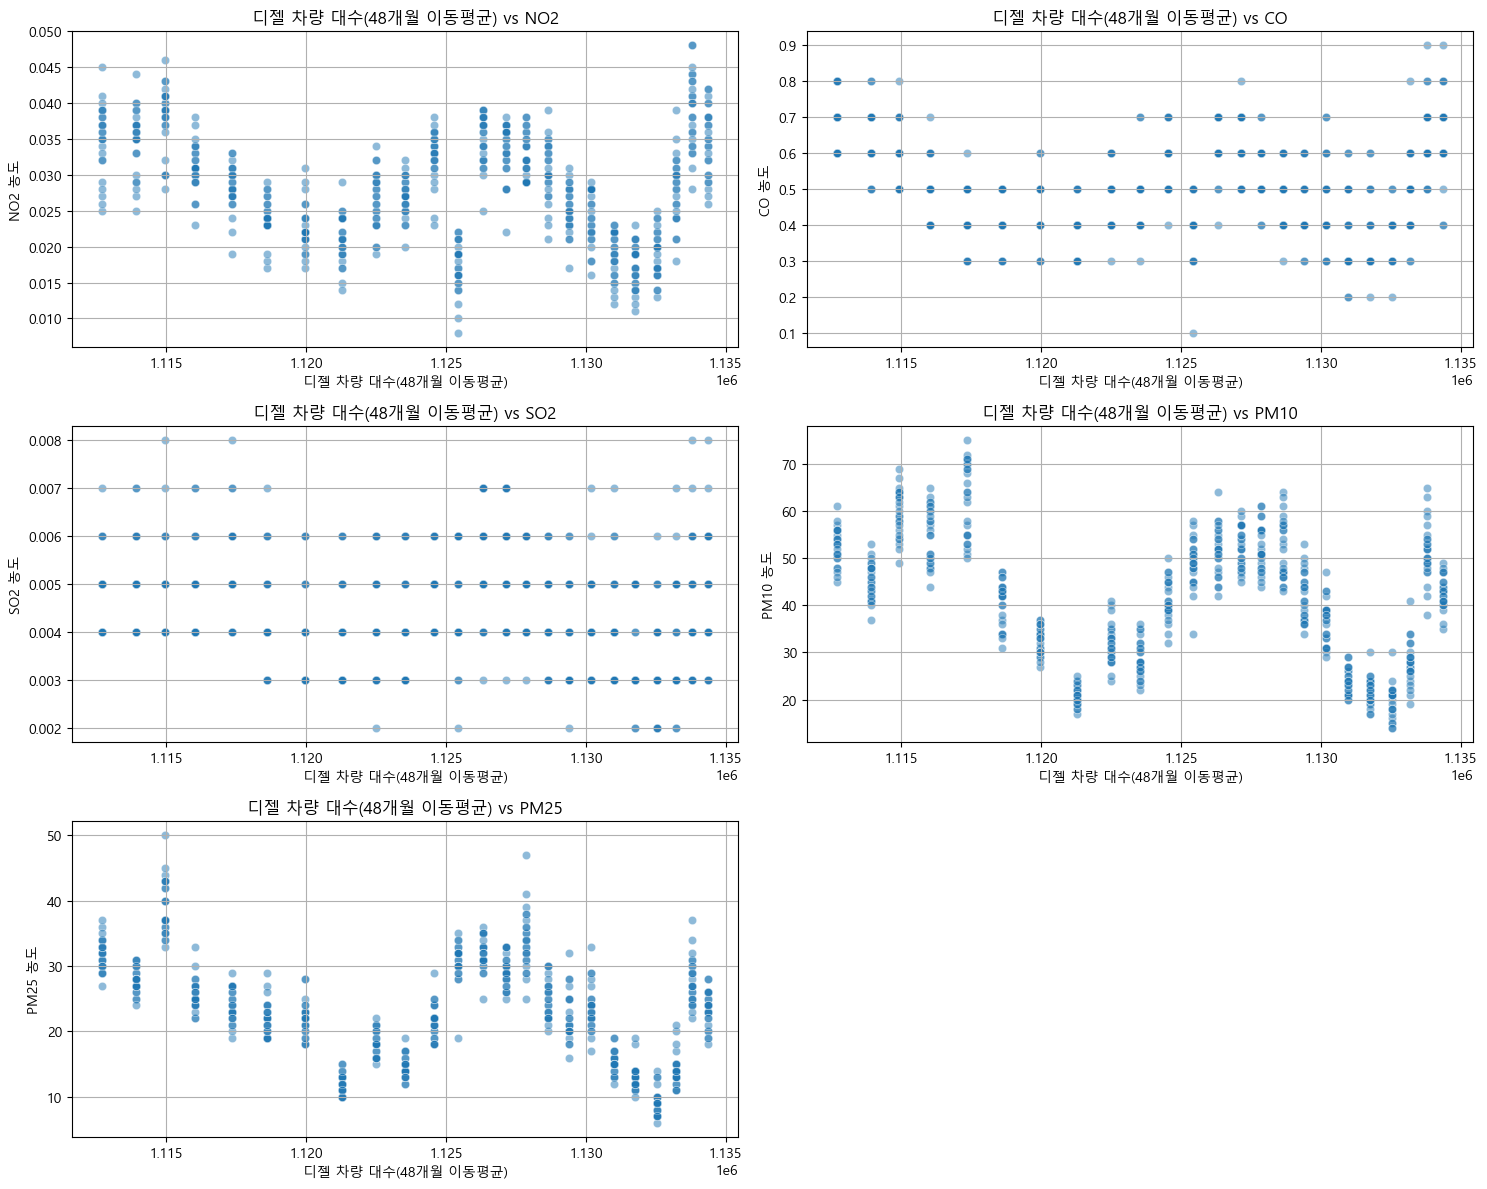

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 파일 불러오기 (예시 경로, 실제 경로로 수정)
df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')  # 실제 파일명/경로로 변경

# 2. 데이터 전처리
df = df.sort_values(['region', 'datetime'])
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel'])

# 3. 48개월 이동평균 변수 추가
df['diesel_ma48'] = df.groupby('region')['diesel'].rolling(window=48, min_periods=1).mean().reset_index(level=0, drop=True)
df = df.dropna()

# 4. 오염물질 리스트
pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

# 5. 산점도 그리기 (5개 오염물질 한 번에)
plt.figure(figsize=(15, 12))
for i, pol in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=df, x='diesel_ma48', y=pol, alpha=0.5)
    plt.title(f'디젤 차량 대수(48개월 이동평균) vs {pol.upper()}')
    plt.xlabel('디젤 차량 대수(48개월 이동평균)')
    plt.ylabel(f'{pol.upper()} 농도')
    plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 데이터 불러오기
df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')

# 예시: 강남구 데이터만 추출
df_gangnam = df[df['region'] == '강남구'].copy()
df_gangnam['datetime'] = pd.to_datetime(df_gangnam['datetime'])
df_gangnam = df_gangnam.sort_values('datetime')

# 결측치 제거 및 필요한 열만 선택
df_gangnam = df_gangnam[['datetime', 'no2', 'diesel']].dropna()

# Granger causality test (maxlag=3 예시)
test_data = df_gangnam[['no2', 'diesel']]
result = grangercausalitytests(test_data, maxlag=3, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0076  , p=0.9314  , df_denom=20, df_num=1
ssr based chi2 test:   chi2=0.0087  , p=0.9255  , df=1
likelihood ratio test: chi2=0.0087  , p=0.9255  , df=1
parameter F test:         F=0.0076  , p=0.9314  , df_denom=20, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9279  , p=0.0205  , df_denom=17, df_num=2
ssr based chi2 test:   chi2=12.7547 , p=0.0017  , df=2
likelihood ratio test: chi2=10.0600 , p=0.0065  , df=2
parameter F test:         F=4.9279  , p=0.0205  , df_denom=17, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1543  , p=0.1391  , df_denom=14, df_num=3
ssr based chi2 test:   chi2=9.6944  , p=0.0214  , df=3
likelihood ratio test: chi2=7.9707  , p=0.0466  , df=3
parameter F test:         F=2.1543  , p=0.1391  , df_denom=14, df_num=3


c:\ex\anaconda\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


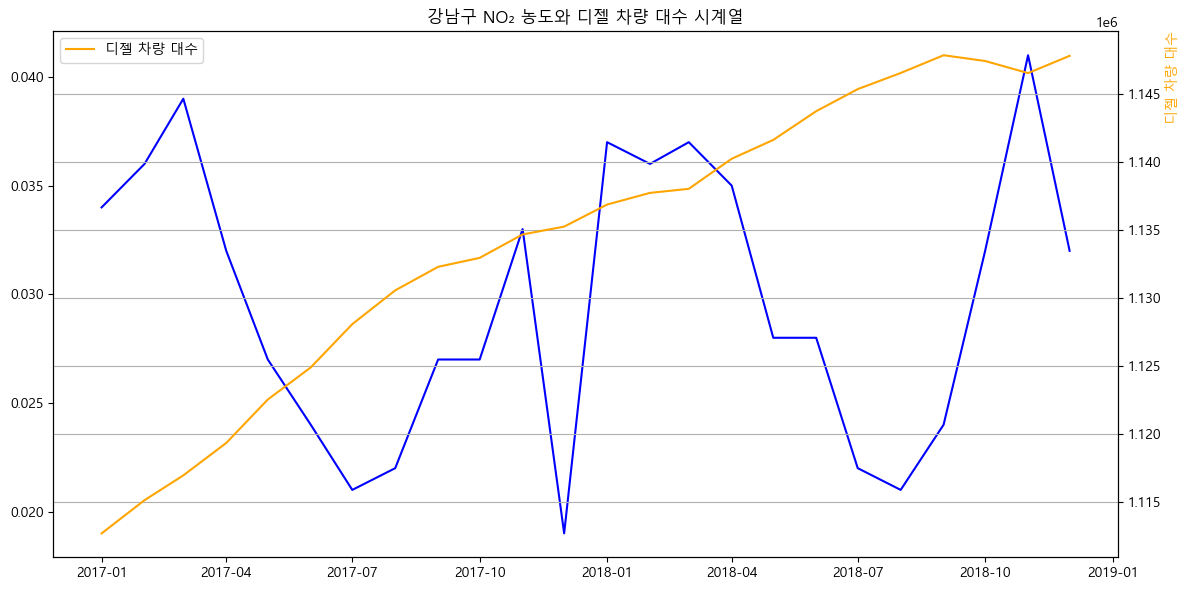

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# NO₂ 농도 시계열
plt.plot(df_gangnam['datetime'], df_gangnam['no2'], label='NO₂ 농도', color='blue')

# 디젤 차량 대수 시계열 (스케일 조정)
plt.twinx()  # 두 번째 y축 생성
plt.plot(df_gangnam['datetime'], df_gangnam['diesel'], label='디젤 차량 대수', color='orange')

# 범례 및 라벨
plt.title('강남구 NO₂ 농도와 디젤 차량 대수 시계열')
plt.xlabel('날짜')
plt.ylabel('NO₂ 농도', color='blue')
plt.ylabel('디젤 차량 대수', color='orange', loc='top')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# PM10 농도 시계열
plt.plot(df_gangnam['datetime'], df_gangnam['pm10'], label='PM10 농도', color='blue')

# 디젤 차량 대수 시계열 (스케일 조정)
plt.twinx()  # 두 번째 y축 생성
plt.plot(df_gangnam['datetime'], df_gangnam['diesel'], label='디젤 차량 대수', color='orange')

# 범례 및 라벨
plt.title('강남구 NO₂ 농도와 디젤 차량 대수 시계열')
plt.xlabel('날짜')
plt.ylabel('PM10 농도', color='blue')
plt.ylabel('디젤 차량 대수', color='orange', loc='top')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'pm10'

<Figure size 1200x600 with 0 Axes>

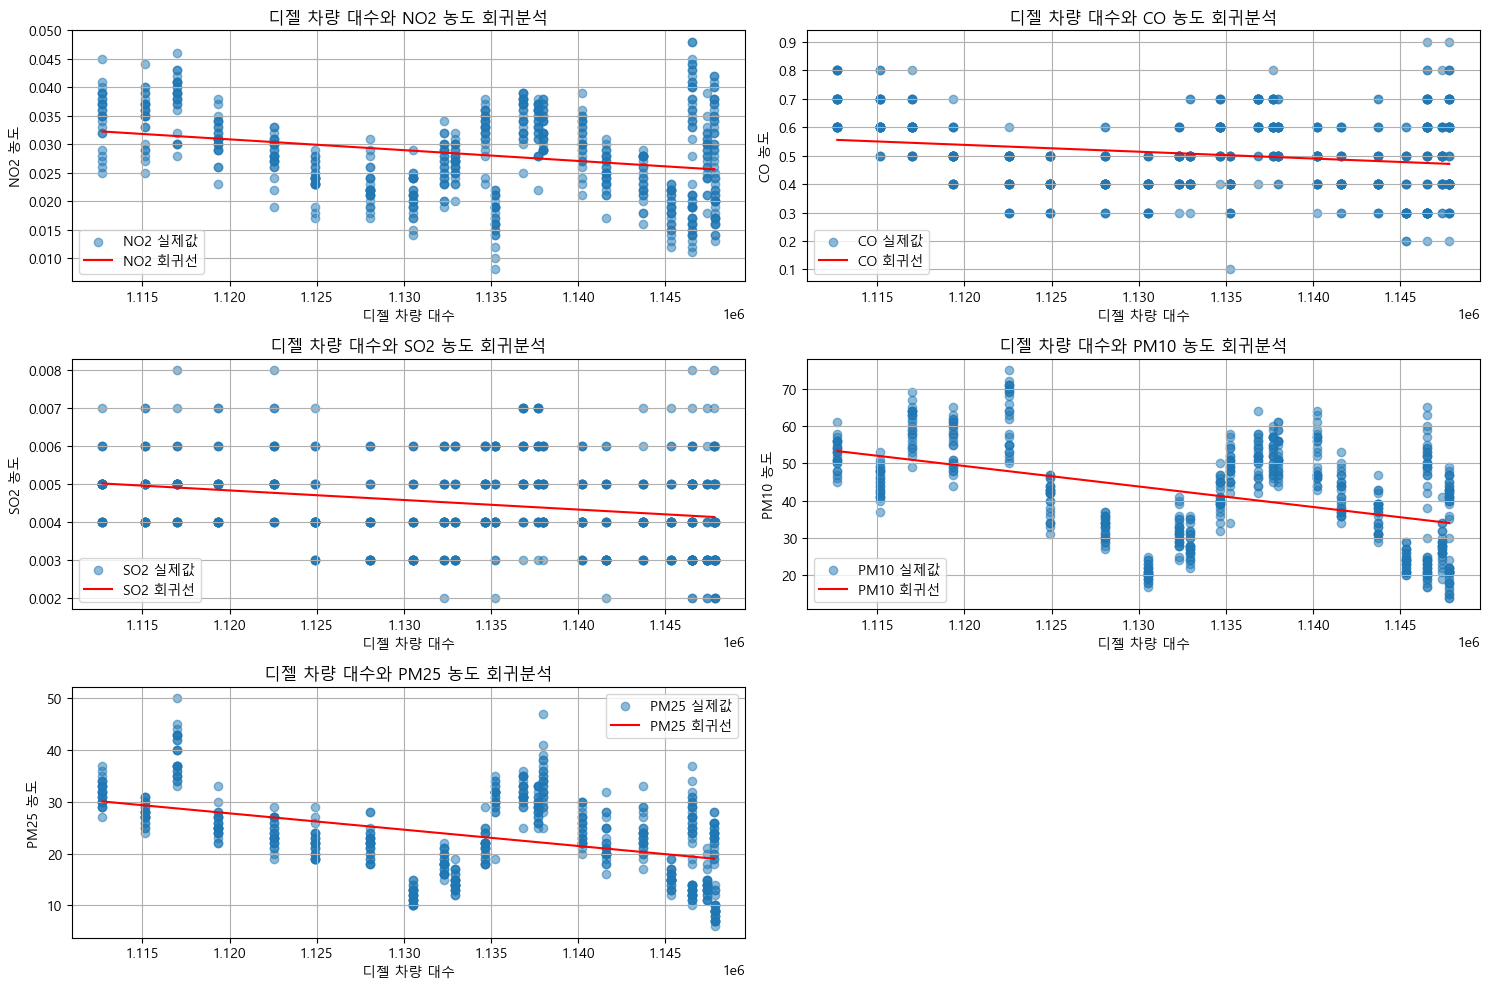

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel'])

pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

plt.figure(figsize=(15, 10))
for i, pol in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    X = sm.add_constant(df['diesel'])
    y = df[pol]
    model = sm.OLS(y, X).fit()
    plt.scatter(df['diesel'], y, alpha=0.5, label=f'{pol.upper()} 실제값')
    plt.plot(df['diesel'], model.predict(X), color='red', label=f'{pol.upper()} 회귀선')
    plt.xlabel('디젤 차량 대수')
    plt.ylabel(f'{pol.upper()} 농도')
    plt.title(f'디젤 차량 대수와 {pol.upper()} 농도 회귀분석')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

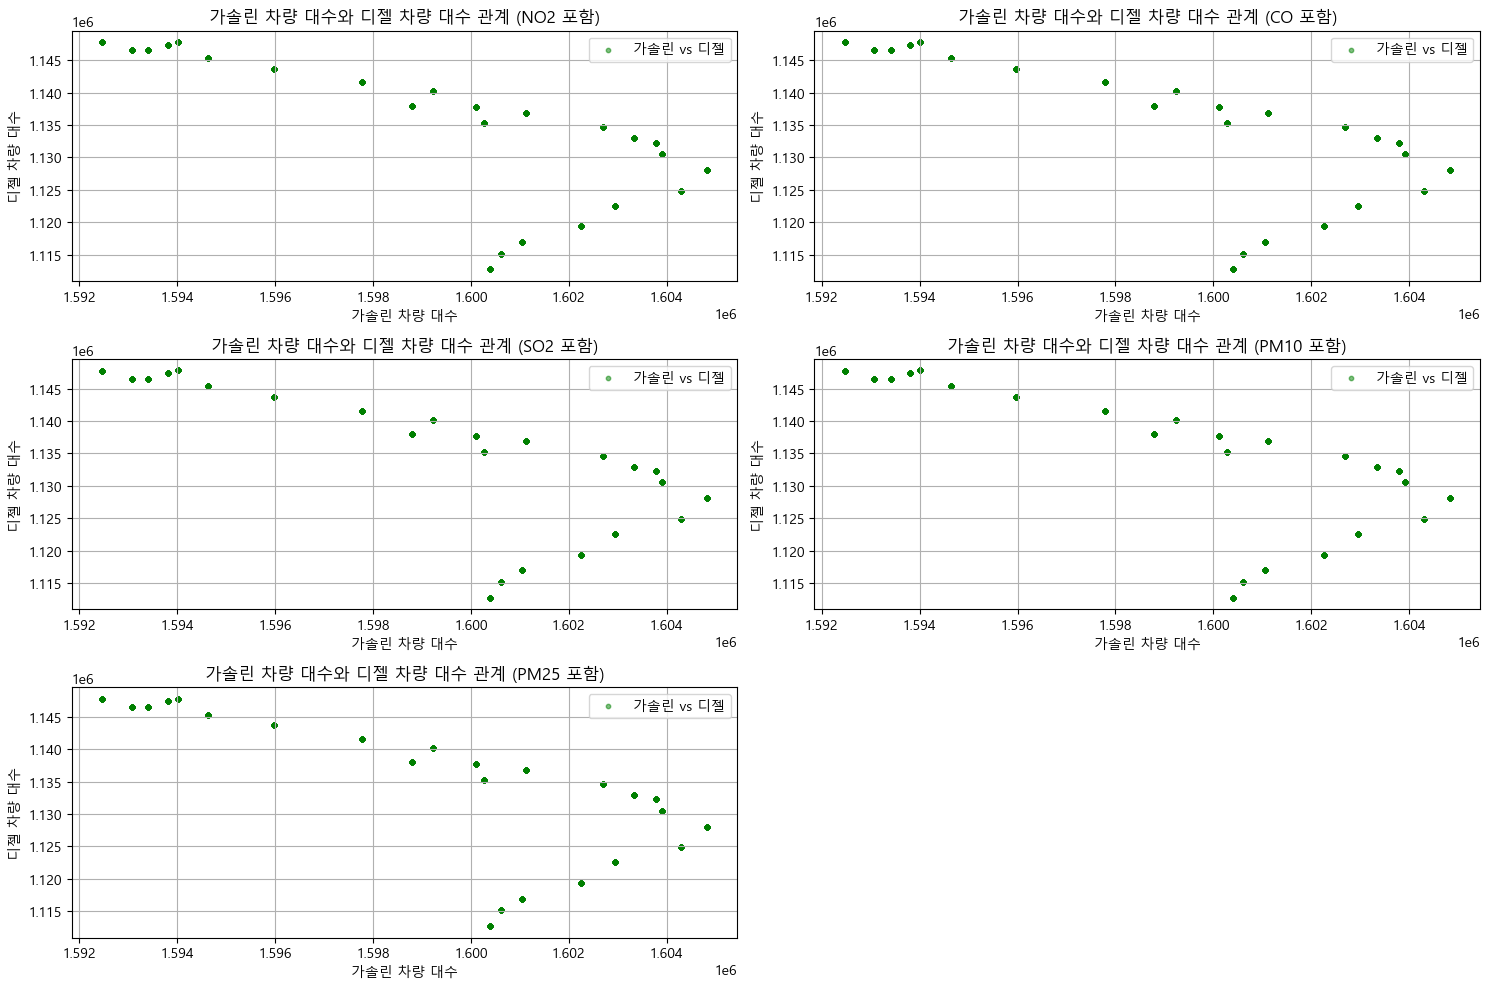

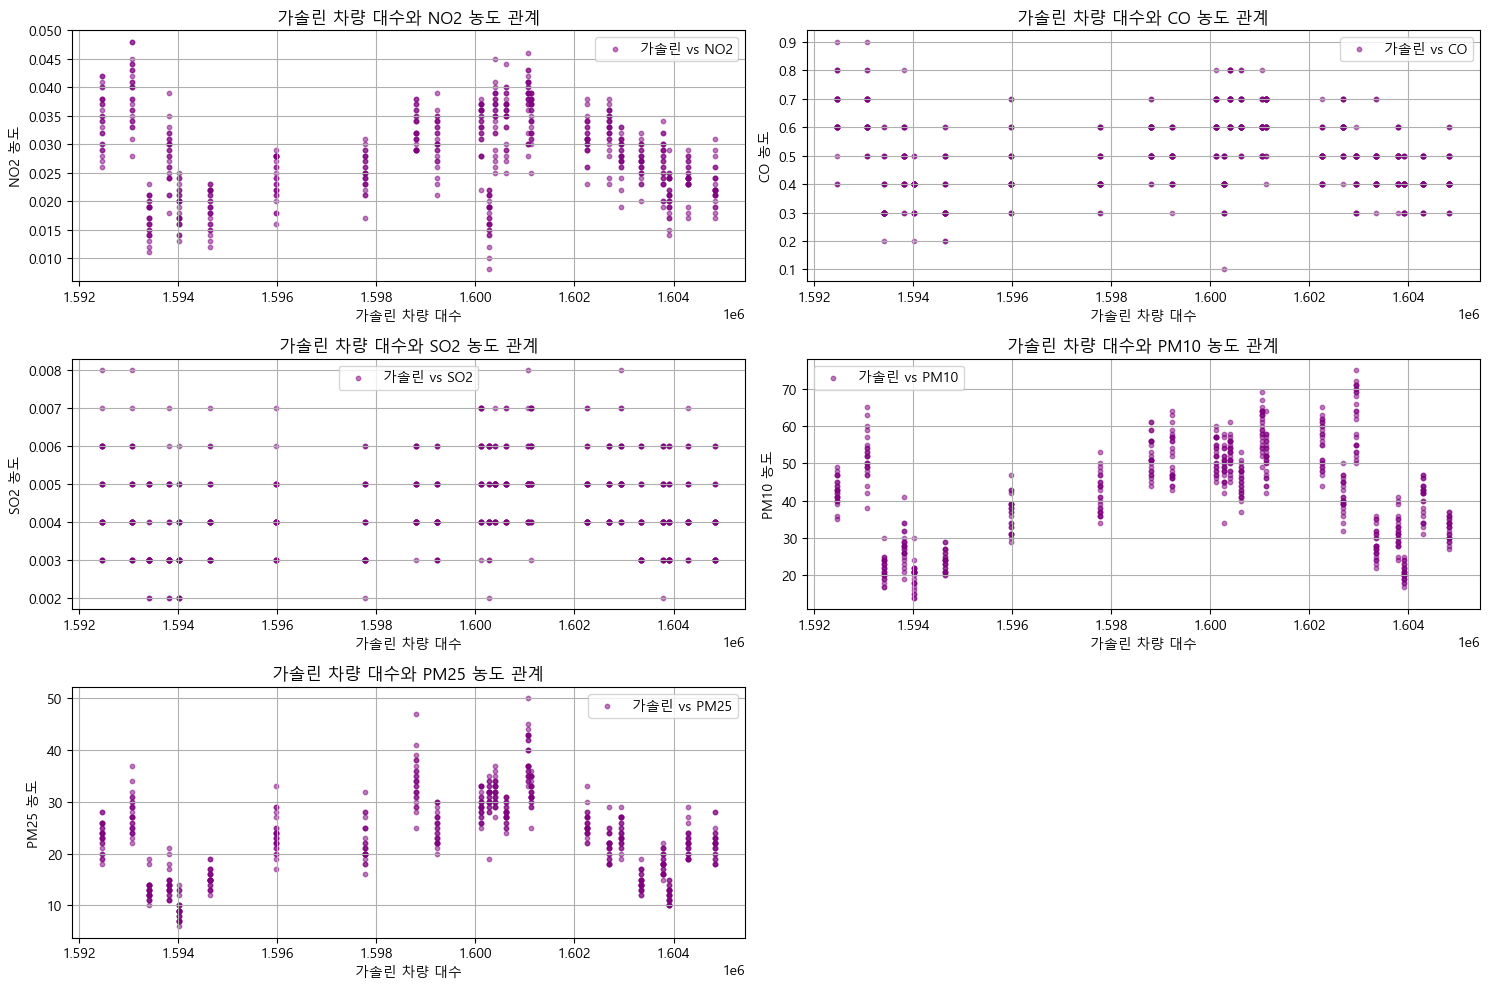

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel', 'gasoline'])

pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

plt.figure(figsize=(15, 10))
for i, pol in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    plt.scatter(df['gasoline'], df['diesel'], alpha=0.5, label='가솔린 vs 디젤', color='green', s=10)
    plt.xlabel('가솔린 차량 대수')
    plt.ylabel('디젤 차량 대수')
    plt.title(f'가솔린 차량 대수와 디젤 차량 대수 관계 ({pol.upper()} 포함)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, pol in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    plt.scatter(df['gasoline'], df[pol], alpha=0.5, label=f'가솔린 vs {pol.upper()}', color='purple', s=10)
    plt.xlabel('가솔린 차량 대수')
    plt.ylabel(f'{pol.upper()} 농도')
    plt.title(f'가솔린 차량 대수와 {pol.upper()} 농도 관계')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

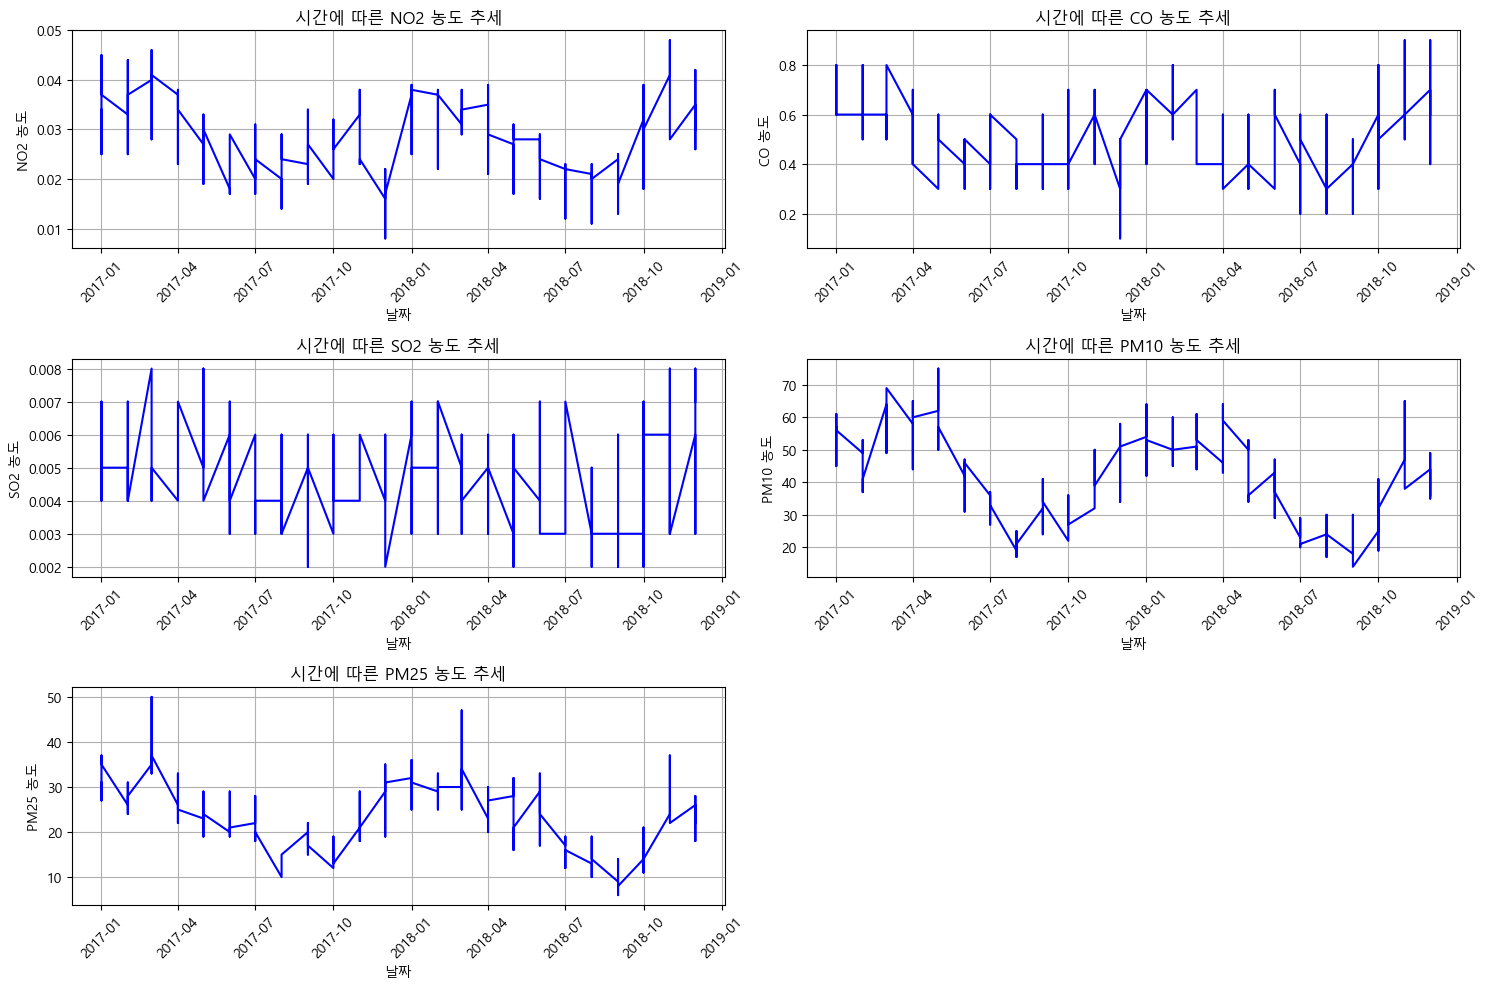

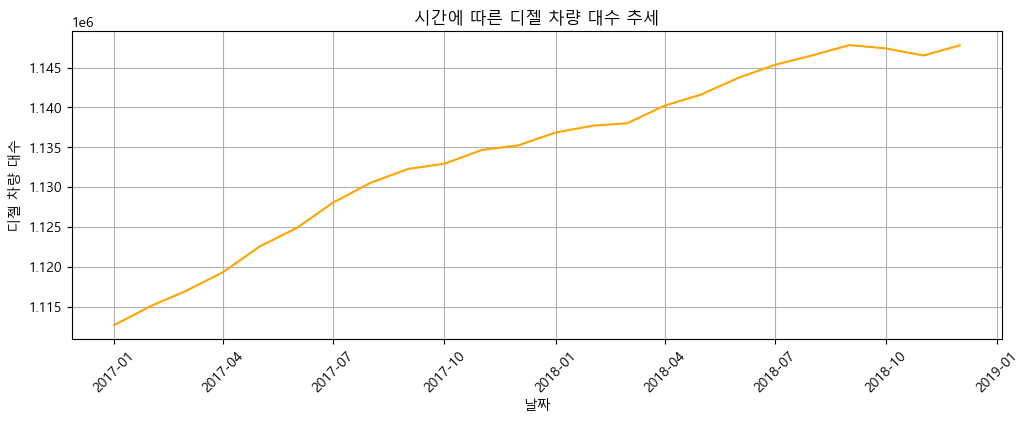

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel'])
df = df.sort_values('datetime')

pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

plt.figure(figsize=(15, 10))
for i, pol in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    plt.plot(df['datetime'], df[pol], label=f'{pol.upper()} 농도', color='blue')
    plt.xlabel('날짜')
    plt.ylabel(f'{pol.upper()} 농도')
    plt.title(f'시간에 따른 {pol.upper()} 농도 추세')
    plt.grid(True)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 디젤 차량 대수 시계열도 추가로 그릴 수 있음
plt.figure(figsize=(12, 4))
plt.plot(df['datetime'], df['diesel'], label='디젤 차량 대수', color='orange')
plt.xlabel('날짜')
plt.ylabel('디젤 차량 대수')
plt.title('시간에 따른 디젤 차량 대수 추세')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

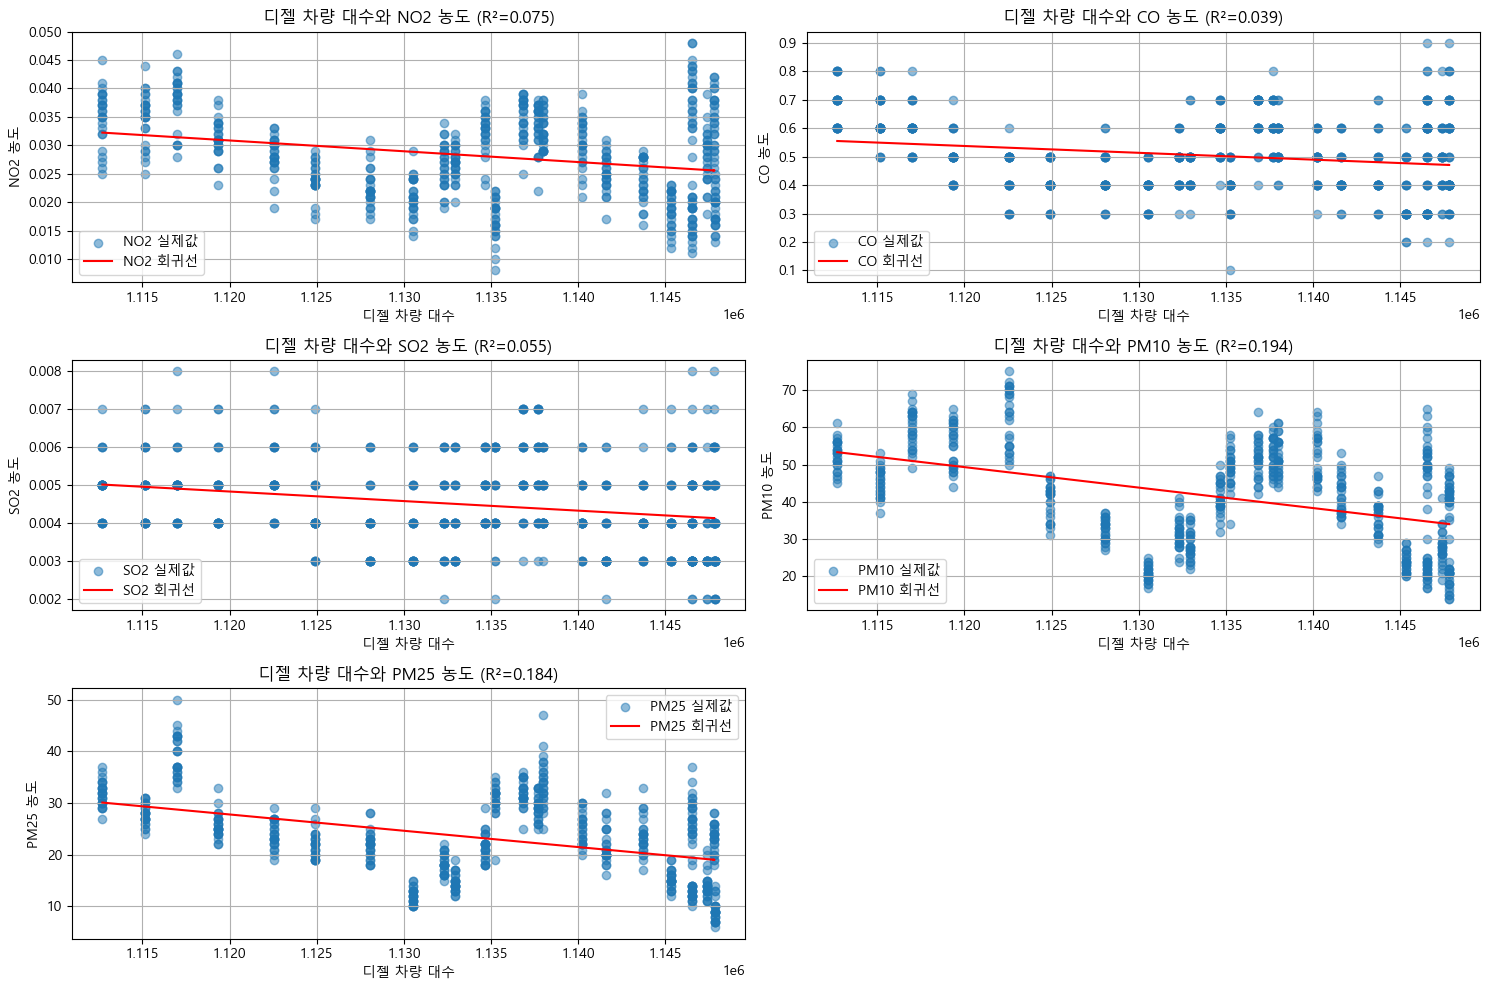

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 데이터 불러오기
df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel'])
pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

plt.figure(figsize=(15, 10))
for i, pol in enumerate(pollutants, 1):
    # 회귀분석
    X = sm.add_constant(df['diesel'])
    y = df[pol]
    model = sm.OLS(y, X).fit()
    r2 = model.rsquared  # R² 점수

    # 그래프 그리기
    plt.subplot(3, 2, i)
    plt.scatter(df['diesel'], y, alpha=0.5, label=f'{pol.upper()} 실제값')
    plt.plot(df['diesel'], model.predict(X), color='red', label=f'{pol.upper()} 회귀선')
    plt.xlabel('디젤 차량 대수')
    plt.ylabel(f'{pol.upper()} 농도')
    plt.title(f'디젤 차량 대수와 {pol.upper()} 농도 (R²={r2:.3f})')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

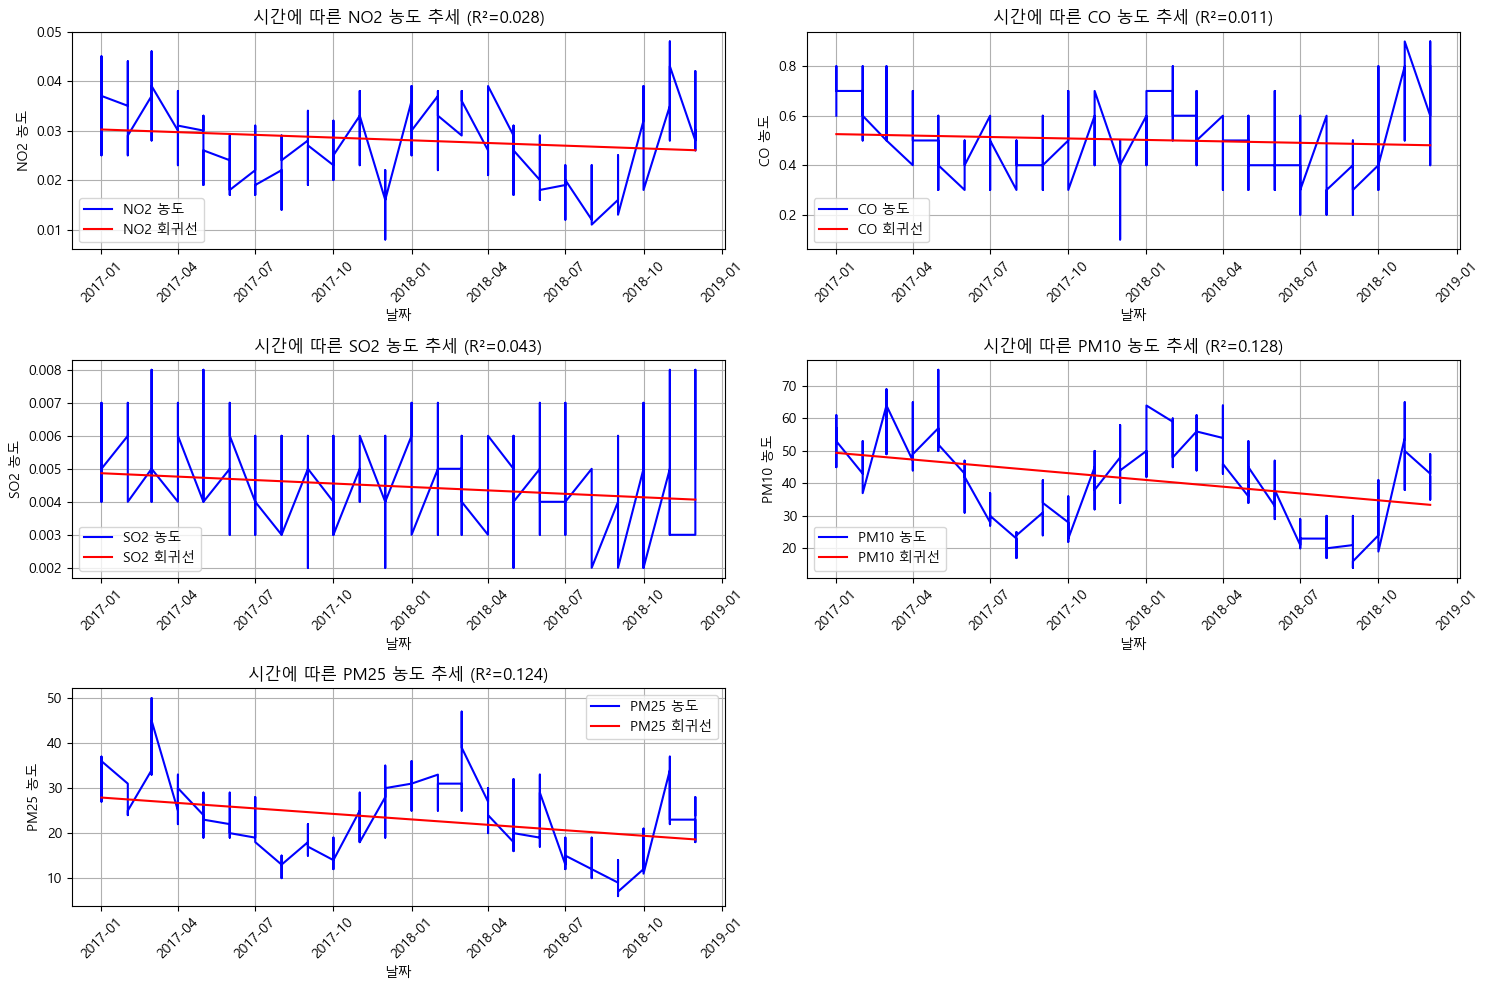

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel'])

# 시간(날짜)를 숫자로 변환 (예: 일수, 월수 등)
df['time_num'] = (df['datetime'] - df['datetime'].min()).dt.days

pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

plt.figure(figsize=(15, 10))
for i, pol in enumerate(pollutants, 1):
    X = sm.add_constant(df['time_num'])
    y = df[pol]
    model = sm.OLS(y, X).fit()
    r2 = model.rsquared

    plt.subplot(3, 2, i)
    plt.plot(df['datetime'], y, label=f'{pol.upper()} 농도', color='blue')
    plt.plot(df['datetime'], model.predict(X), label=f'{pol.upper()} 회귀선', color='red')
    plt.xlabel('날짜')
    plt.ylabel(f'{pol.upper()} 농도')
    plt.title(f'시간에 따른 {pol.upper()} 농도 추세 (R²={r2:.3f})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

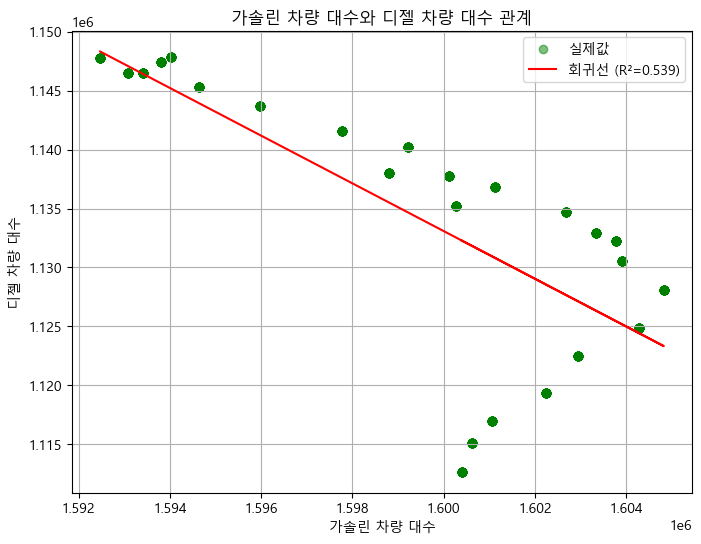

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv(
                 )
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel', 'gasoline'])

pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

# 가솔린 차량 대수와 디젤 차량 대수 관계 (R²)
X = sm.add_constant(df['gasoline'])
y = df['diesel']
model = sm.OLS(y, X).fit()
r2 = model.rsquared

plt.figure(figsize=(8, 6))
plt.scatter(df['gasoline'], df['diesel'], alpha=0.5, label='실제값', color='green')
plt.plot(df['gasoline'], model.predict(X), color='red', label=f'회귀선 (R²={r2:.3f})')
plt.xlabel('가솔린 차량 대수')
plt.ylabel('디젤 차량 대수')
plt.title('가솔린 차량 대수와 디젤 차량 대수 관계')
plt.legend()
plt.grid(True)
plt.show()

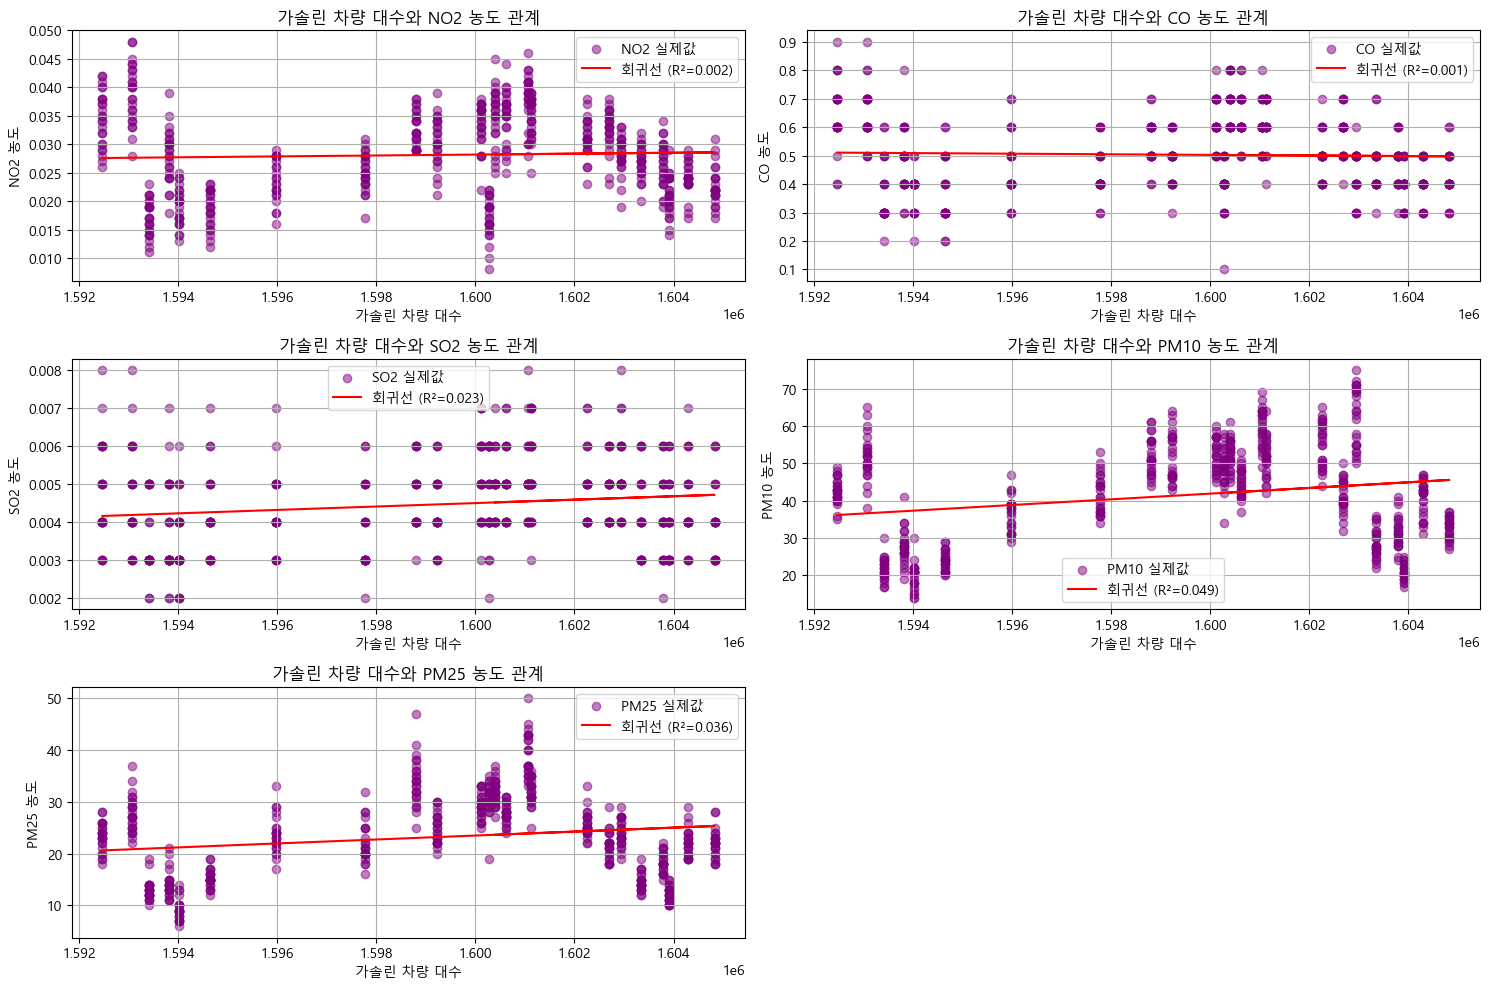

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv(r'C:\Users\USER\Documents\ai-proj2-class4\20.data-preprocessing\전기차용_데이터셋.csv')
df = df.dropna(subset=['no2', 'co', 'so2', 'pm10', 'pm25', 'diesel', 'gasoline'])

pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']

plt.figure(figsize=(15, 10))
for i, pol in enumerate(pollutants, 1):
    X = sm.add_constant(df['gasoline'])
    y = df[pol]
    model = sm.OLS(y, X).fit()
    r2 = model.rsquared

    plt.subplot(3, 2, i)
    plt.scatter(df['gasoline'], y, alpha=0.5, label=f'{pol.upper()} 실제값', color='purple')
    plt.plot(df['gasoline'], model.predict(X), color='red', label=f'회귀선 (R²={r2:.3f})')
    plt.xlabel('가솔린 차량 대수')
    plt.ylabel(f'{pol.upper()} 농도')
    plt.title(f'가솔린 차량 대수와 {pol.upper()} 농도 관계')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()